# Домашнее задание по теме "Ансамблирование"

## Задание

Цель: применить на практике базовые ансамблевые методы
Описание задания:
В домашнем задании нужно решить задачу классификации наличия болезни сердца у пациентов. Данные для обучения моделей необходимо загрузить самостоятельно с сайта (heart.csv). Целевая переменная – наличие болезни сердца (HeartDisease), принимает значения 0 или 1 в зависимости от отсутствия или наличия болезни соответственно. (Подробнее о признаках можно прочесть в описании датасета на сайте. Для выполнения работы не обязательно вникать в медицинские показатели.)

## Этапы работы

1. Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую)
1. Подготовьте датасет к обучению моделей.
    - Категориальные переменные переведите в цифровые значения. Можно использовать pd.get_dummies, preprocessing.LabelEncoder. Старайтесь не использовать для этой задачи циклы.
    - Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака).
1. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.
1. Обучите дерево решений на обучающем множестве. Используйте следующие модели:
    - tree.DecisionTreeClassifier
    - ensemble.RandomForestClassifier
1. Для тестового множества сделайте предсказание целевой переменной. Выведите метрики для каждой построенной модели с помощью metrics.classification_report.
1. Выведите важность признаков, полученную после обучения модели из п. 4b в виде столбчатой диаграммы. Отсортируйте важность по убыванию.
1. Обучите бэггинг над моделью из п. 4a. Используйте ensemble.BaggingClassifier.
    - Повторите п. 5
1. Обучите стекинг трех моделей: из п. 4a, п. 4b и svm.LinearSVC. Используйте ensemble.StackingClassifier.
    - Повторите п. 5
1. Сформулируйте выводы по проделанной работе.
    - Сравните метрики построенных моделей.
    - Напишите свое мнение, какая модель наилучшая и почему.

Для получения зачета по этому домашнему заданию, минимально, должны быть обучены следующие модели: дерево решений, стекинг трех моделей. В данных должны быть обработаны категориальные значения.

In [58]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

## 1. Получение и загрузка данных

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.shape

(918, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

**Вывод**: в датафрейме нет пропусков значений и все типы данных соответствуют значениям.

## 2. Готовим датасет к обучению моделей

### 2.1 Работаем с категориальными значениями

Для преобразование категориальных данных в числовые применим **OneHotEncoder**:

In [6]:
categorials = df.select_dtypes('object').columns
categorials

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [7]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[categorials])

OneHotEncoder(sparse_output=False)

In [8]:
df[ohe.get_feature_names_out()] = ohe.transform(df[categorials])
df.shape

(918, 26)

Удалим признаки с категориальными значениями:

In [9]:
df = df.drop(categorials, axis=1)
df.shape

(918, 21)

In [10]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,150,195,0,122,0.0,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


**Вывод**: в результате создано 14 новых признаков с числовыми значениями.

### 2.2 Построение графиков

Посмотрим распределение пациентов в каждой группе по возрасту:

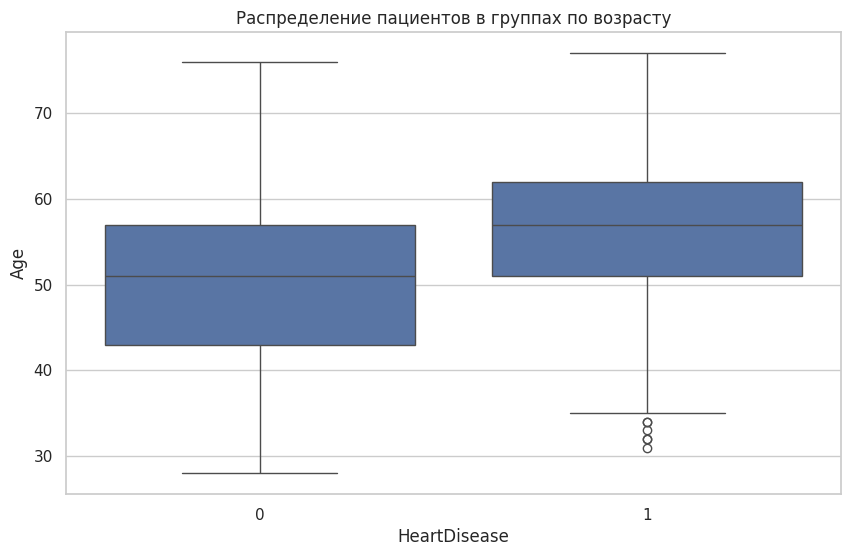

In [25]:
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_theme(style="whitegrid")
sns.boxplot(
    x='HeartDisease',
    y='Age',
    data=df
)
plt.title('Распределение пациентов в группах по возрасту')
plt.show()

In [22]:
sex = df.groupby('HeartDisease').agg({'Sex_F': 'sum', 'Sex_M': 'sum'})
sex

,Sex_F,Sex_M
HeartDisease,,
0,143.0,267.0
1,50.0,458.0


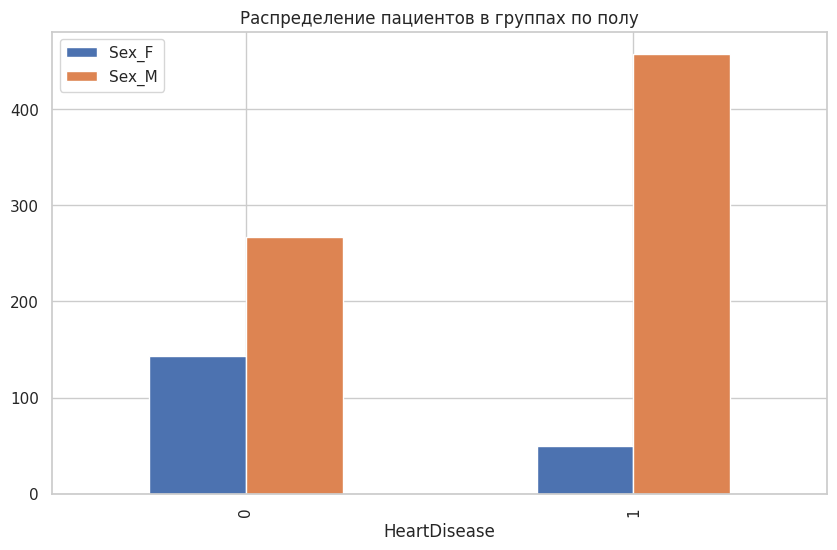

In [26]:
sex.plot(kind='bar')
plt.title('Распределение пациентов в группах по полу')
plt.show()

**Вывод**:
- болезни сердца развиваются у людеу более старшего возраста;
- болезни сердца развиваются чаще у мужчин,чем у женщин.

## 3. Делим датасет на обучающую и тестовую выборки

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='HeartDisease'),
                                                    df['HeartDisease'],
                                                    test_size=0.2,
                                                    random_state=10)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((734, 20), (184, 20), (734,), (184,))

## 4. Обучаем деревья решений

### 4.1 Дерево решений

In [32]:
clf_tree = DecisionTreeClassifier(random_state=10)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

### 4.2 Случайный лес

In [33]:
clf_rf = RandomForestClassifier(random_state=10)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

## 5. Предсказания целевой переменной на тестовой выборке, метрики качества модели

### 5.1 Дерево решений

In [35]:
tree_predict = clf_tree.predict(X_test)

In [37]:
print(classification_report(y_test, tree_predict))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74        86
           1       0.77      0.76      0.76        98

    accuracy                           0.75       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.75      0.75      0.75       184



### 5.2 Случайный лес

In [38]:
rf_predict = clf_rf.predict(X_test)

In [39]:
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82        86
           1       0.83      0.88      0.85        98

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.84       184
weighted avg       0.84      0.84      0.84       184



**Вывод**: Модель, построенная на Random Forrest показала лучшие результаты по сравнению с моделью Decision Tree

## 6. Важность признаков в модели Random Forrest

In [44]:
importances = pd.Series(clf_rf.feature_importances_)
importances.index = pd.Series(X_train.columns)
importances = importances.sort_values(ascending=False)

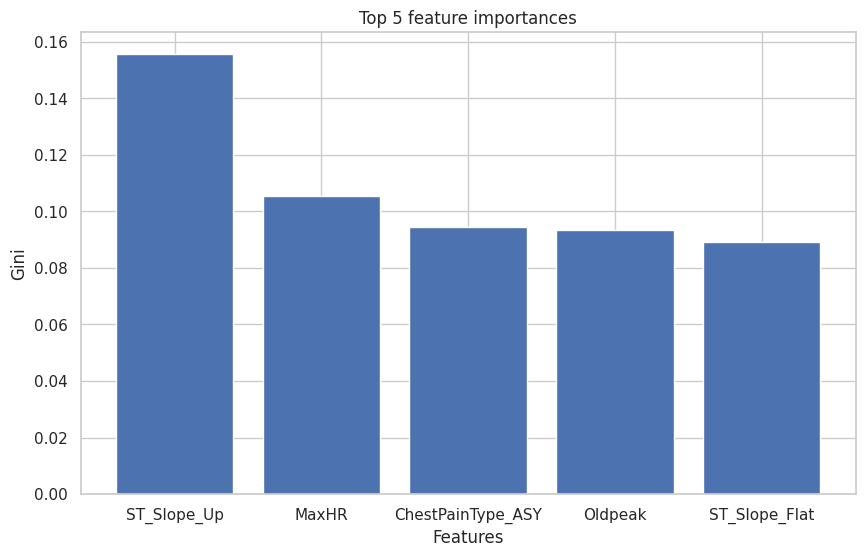

In [45]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(importances.head().index, importances.head())
plt.show()

## 7. Бэггинг

In [49]:
clf_bagg = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=200,
    max_samples=0.5,
    max_features=0.5,
    random_state=10
)
clf_bagg.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.5,
                  max_samples=0.5, n_estimators=200, random_state=10)

In [50]:
bagg_predict = clf_bagg.predict(X_test)

In [51]:
print(classification_report(y_test, bagg_predict))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        86
           1       0.84      0.91      0.87        98

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



## 8. Стекинг

In [59]:
clf_stack = StackingClassifier(
    [
        ('clf_tree', clf_tree),
        ('clf_rf', clf_rf),
        ('LinearSVC', make_pipeline(StandardScaler(),
                                    LinearSVC(dual='auto', random_state=10)))
    ], LogisticRegression()
)

In [60]:
clf_stack.fit(X_train, y_train)

StackingClassifier(estimators=[('clf_tree',
                                DecisionTreeClassifier(random_state=10)),
                               ('clf_rf',
                                RandomForestClassifier(random_state=10)),
                               ('LinearSVC',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(dual='auto',
                                                           random_state=10))]))],
                   final_estimator=LogisticRegression())

In [61]:
stack_predict = clf_stack.predict(X_test)

In [62]:
print(classification_report(y_test, stack_predict))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87        86
           1       0.88      0.89      0.88        98

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



## 9. Выводы

Сводная таблица результатов применения моделей:

In [99]:
predicts = [tree_predict, rf_predict, bagg_predict, stack_predict]
indxs = ['Decision Tree', 'Random Forrest', 'Bagging', 'Stacking']

In [101]:
df = pd.DataFrame()
for i, j in zip(predicts, indxs):
    report = classification_report(y_test, i, output_dict=True)['1']
    df_ = pd.DataFrame(report, index=[j])
    df = pd.concat([df, df_])
df

,precision,recall,f1-score,support
Decision Tree,0.770833,0.755102,0.762887,98.0
Random Forrest,0.826923,0.877551,0.851485,98.0
Bagging,0.839623,0.908163,0.872549,98.0
Stacking,0.878788,0.887755,0.883249,98.0


- Лучшие результаты были получены при использовании **Stacking**.
- По всей видимости комбинация моделей, построенных на основе дереврьев решений, случайных лесов и линейных моделей дает лучший результат, чем применение каждой из них по отдельности.